In [146]:
from prevelop_018 import load_data, clear_cad_data, select_data, merge_data, preprocessing, gower_distance, plot_dendrogram, elbow_plot, first_clusters
from collections import Counter
import matplotlib.pyplot as plt

__Data Preparation and Preprocessing__

In [65]:
### Load the data
# Load the cad-data
cad_data = load_data(r"C:\Users\IM-KI\Documents\PrEvelOp_CAPicard\screw_elements\PrEvelOp_CAD_Export_screw-elements.xlsx")
# load process-data
process_data = load_data(r"C:\Users\IM-KI\Documents\PrEvelOp_CAPicard\screw_elements\Arbeitspläne.xlsx")
# load link data
link_data = load_data(r"C:\Users\IM-KI\Documents\PrEvelOp_CAPicard\screw_elements\Teile-Zeichnungen.xlsx")

In [66]:
### clear data
# for cad-data received from SIMUS, apply the following cleaning steps
cad_data = clear_cad_data(cad_data)

In [67]:
### select the data
cad_data, process_data, link_data = select_data(cad_data, process_data, link_data, 'Zeichnung', 'Teil')

In [68]:
# fill nan values with 0
cad_data = cad_data.fillna(0)

(0.0, 18.0)

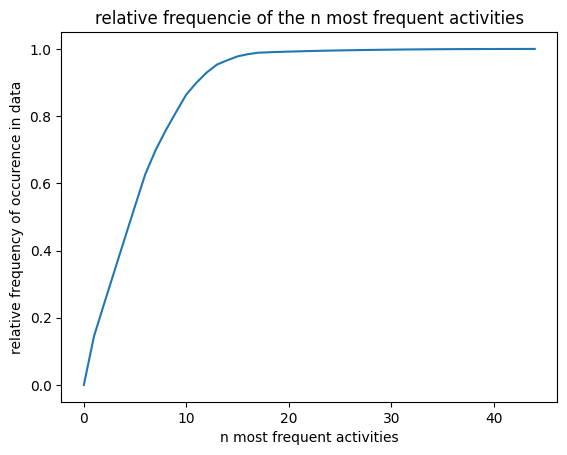

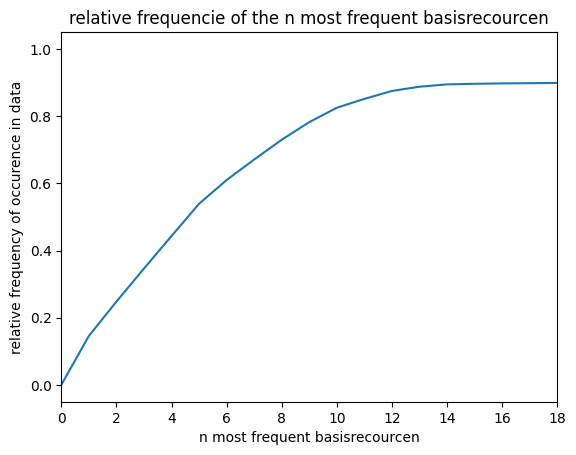

In [69]:
### aggregate process data
# create a new dataframe to store the aggregated data
process_data_2 = link_data.copy()
teile_list = process_data_2['Teil'].tolist()

nr_aktivitaeten = []
aktivitaeten = []
basisrecourcen = []
produktionsmenge = []
soll_te = []
soll_tr = []

for teil in teile_list:
    teil_data = process_data[process_data['Teil'] == teil]
    # drop duplicates in teil_data on AkvP
    teil_data.drop_duplicates(subset=['AkvP'], inplace=True)
    nr_aktivitaeten.append(teil_data.shape[0])
    aktivitaeten.append(teil_data['Aktivität'].tolist())
    basisrecourcen.append(teil_data['Basisressource'].tolist())
    produktionsmenge.append(teil_data['Produktionsmenge'].median())
    if produktionsmenge[-1] == 0:
        soll_te.append(teil_data['Soll te'].mean())
    else:
        soll_te.append(teil_data['Soll te'].mean()/produktionsmenge[-1])
    soll_tr.append(teil_data['Soll tr'].mean())

# save aggregated data in the new dataframe
process_data_2['Nr. Aktivitäten'] = nr_aktivitaeten
process_data_2['Aktivitäten'] = aktivitaeten
process_data_2['Basisressource'] = basisrecourcen
process_data_2['Soll te'] = soll_te
process_data_2['Soll tr'] = soll_tr

# create list with all possible activities
aktivitaeten_cleared = [process for process in aktivitaeten if type(process)!=float]
alle_aktivitaeten = list(set([aktivitaet for process in aktivitaeten_cleared for aktivitaet in process]))
count_aktivitaeten = [aktivitaet for process in aktivitaeten_cleared for aktivitaet in process]
# number of activities
a = sum(list(Counter(count_aktivitaeten).values()))
# number of the n most frequent activities
x_values = range(len(alle_aktivitaeten))
y_values = []
for n in x_values:
    b = sum(sorted(list(Counter(count_aktivitaeten).values()), reverse=True)[:n])
    # relative frequencie of the n most frequent rules
    y_values.append(b/a)

# plot relative frequencie of the n most frequent activities
plt.plot(x_values,y_values)
plt.xlabel('n most frequent activities')
plt.ylabel('relative frequency of occurence in data')
plt.title('relative frequencie of the n most frequent activities')

# create list with all possible basisrecourcen
basisrecourcen_cleared = [ressource for ressource in basisrecourcen if type(ressource)!=float]
alle_basisrecourcen = list(set([ressource for basisrecourcen in basisrecourcen_cleared for ressource in basisrecourcen]))
count_basisrecourcen = [ressource for basisrecourcen in basisrecourcen_cleared for ressource in basisrecourcen]
# number of basisrecourcen
c = sum(list(Counter(count_basisrecourcen).values()))
# number of the n most frequent basisrecourcen
x_values_r = range(len(alle_basisrecourcen))
y_values_r = []
for n in x_values_r:
    d = sum(sorted(list(Counter(count_basisrecourcen).values()), reverse=True)[:n])
    # relative frequencie of the n most frequent basisrecourcen
    y_values_r.append(d/c)

# plot relative frequencie of the n most frequent basisrecourcen
# plot in new figure
plt.figure()
plt.plot(x_values_r,y_values_r)
plt.xlabel('n most frequent basisrecourcen')
plt.ylabel('relative frequency of occurence in data')
plt.title('relative frequencie of the n most frequent basisrecourcen')
plt.xlim(0, 18)

In [70]:
# select the 15 most frequent activities
activities_frequent = [value[0] for value in Counter(count_aktivitaeten).most_common(15)]

# add a column for each of the 15 most frequent activities 
# add 1 if the activitiy appears in the process of the respective row, 0 otherwise
for act in activities_frequent:
    column_values = [1 if act in process else 0 for process in process_data_2['Aktivitäten']]
    process_data_2['Aktivität ' + str(act)] = column_values

# select the 12 most frequent basisrecourcen
basisrecourcen_frequent = [value[0] for value in Counter(count_basisrecourcen).most_common(12)]

# add a column for each of the 12 most frequent basisrecourcen
# add 1 if the basisressource appears in the process of the respective row, 0 otherwise
for res in basisrecourcen_frequent:
    column_values = [1 if res in process else 0 for process in process_data_2['Basisressource']]
    process_data_2['Basisressource ' + str(res)] = column_values

# drop column 'Aktivitäten' and 'Basisressource'
process_data_2 = process_data_2.drop(columns=['Aktivitäten'])
process_data_2 = process_data_2.drop(columns=['Basisressource'])

In [81]:
### merge the data
data = merge_data(cad_data, process_data_2, 'Zeichnung', 'Teil')

In [83]:
### extract data from nomennclature in column 'Teil'
data['Material'] = data.index.str[5:7]
data['Nr. of flights and direction'] = data.index.str[7]
data['Design'] = data.index.str[8]
data['Pitch'] = data.index.str[10:13]
data['Length'] = data.index.str[14:17]

# drop rows with non-numeric values in column 'Pitch' and 'Length'
data = data[data['Pitch'].str.isnumeric()]
data = data[data['Length'].str.isnumeric()]

# make values in columns 'Pitch' and 'Length' numeric
data['Pitch'] = data['Pitch'].astype(float)
data['Length'] = data['Length'].astype(float)

# drop rows with values in Nr of flights and direction not in [0,1,2,3,4,5,6]
data = data[data['Nr. of flights and direction'].isin(['0','1','2','3','4','5','6'])]

# drop rows with values in Design not in [0,1,2,3,4,5]
data = data[data['Design'].isin(['0','1','2','3','4','5'])]

In [90]:
### preprocess the data
# select numerical, binary and categorical columns for preprocessing
num_colums = ['L [mm]', 'B [mm]', 'H [mm]', 'Soll te', 'Soll tr', 'Nr. Aktivitäten', 'Pitch', 'Length', 'Volumen [mm3]', 'Masse [kg]', 'Flächeninhalt [mm2]', 'Da max. [mm]', 'Di min. [mm]']
bin_columns = ['Aktivität ' + str(act) for act in activities_frequent] + ['Basisressource ' + str(res) for res in basisrecourcen_frequent]
cat_columns = ['Klasse','Material','Nr. of flights and direction','Design']

data_preprocessed = preprocessing(data, num_colums, bin_columns, cat_columns)

__Clustering__

In [96]:
### calculate distance matrix
distance_matrix = gower_distance(data)

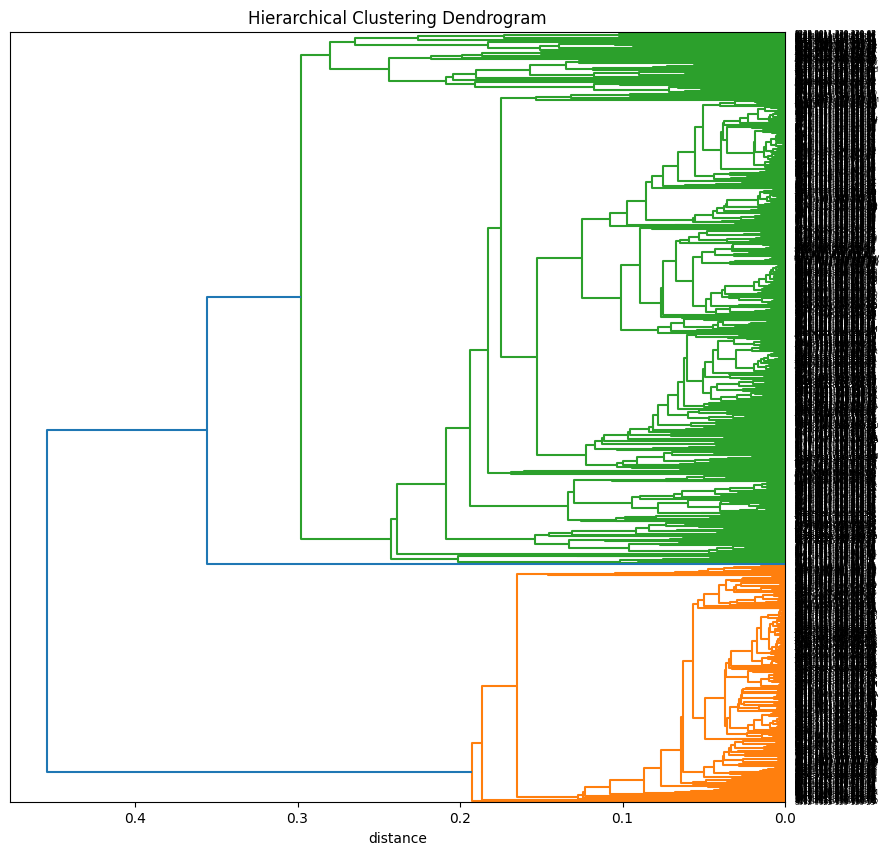

In [101]:
### plot the dendrogram
plot_dendrogram(distance_matrix, labels=data.index, orientation='left')

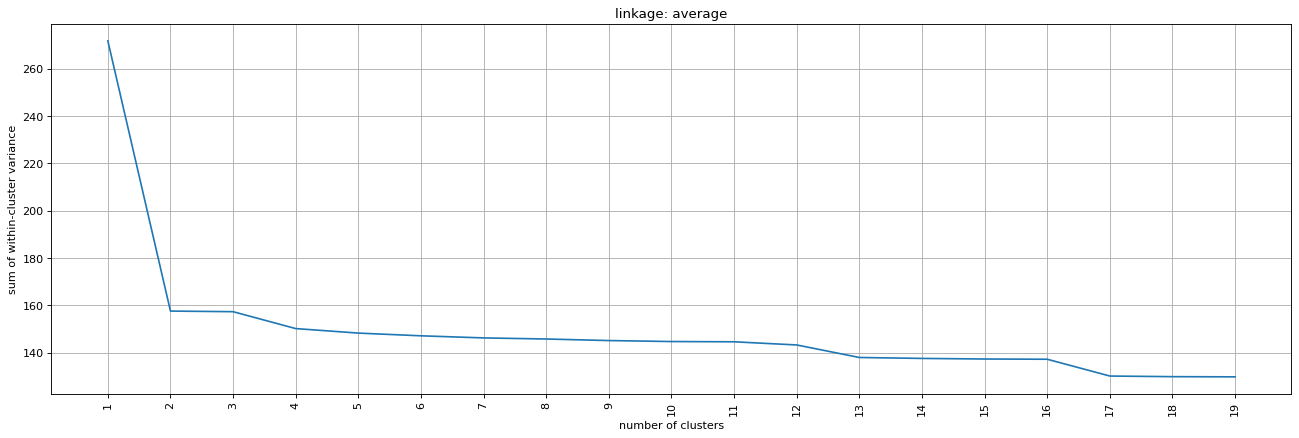

In [106]:
### plot the elbow plot for the first 20 clusters
elbow_plot(data_preprocessed, distance_matrix, 20)

In [109]:
# ### plot silhouette plot for cluster sizes 2, 4, 13, 17
# cluster_sizes = [2, 4, 13, 17]
# silhouette_plot(distance_matrix, cluster_sizes)

In [154]:
### calculate the clusters with the smallest distances
first_clusters(data, distance_matrix, 10)

Cluster: 0
['8238-0011-320-320-67', '8238-0011-320-320-68']
------------------------
Cluster: 1
['Y079-0021-100-678-KA', 'Y079-0021-100-678-KB']
------------------------
Cluster: 2
['K055-2551-050-025-00', 'K055-2551-050-025-01']
------------------------
Cluster: 3
['8120-0032-180-180-35', '8120-0032-180-180-25']
------------------------
Cluster: 4
['8300-0011-300-300-68', '8300-0011-300-300-67']
------------------------
Cluster: 5
['K055-2521-050-050-00', 'K055-2521-050-050-01']
------------------------
Cluster: 7
['J081-PS21-077-077-AJ', 'J081-PS21-077-077-AK']
------------------------
Cluster: 8
['K055-EE22-050-100-05', 'K055-EE22-050-100-06']
------------------------
Cluster: 11
['K055-1521-033-100-00', 'K055-1521-033-100-01']
------------------------
Cluster: 12
['K055-EE21-033-100-00', 'K055-EE21-033-100-01']
------------------------
Cluster: 17
['J081-PS21-096-096-AJ', 'J081-PS21-096-096-AK']
------------------------
Cluster: 35
['J081-PS21-077-039-AJ', 'J081-PS21-077-039-AK']
-